In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2


output = pd.read_csv("Matrix_R_T5_8Layers.dat", sep='\s+')
data_in1 = pd.read_csv("matrix_SiO2.txt", sep='\s+')
data_in2 = pd.read_csv("matrix_ZnS.txt", sep='\s+')

output = output.to_numpy()

data_in1 = data_in1.to_numpy()
data_in2 = data_in2.to_numpy()

data_in2 = data_in2[:, 1:]  # Eliminamos la primera columna repetida

# Dividir la entrada en longitud de onda y índices de refracción
x_train_wavelength = data_in1[:, 0].reshape(-1, 1)  # Primera columna: longitud de onda
x_train_refractive = np.concatenate((data_in1[:, 1:], data_in2[:, :]), axis=1)  # Índices de refracción


x_train, x_temp, y_train, y_temp = train_test_split(np.concatenate((x_train_wavelength, x_train_refractive), axis=1), output, test_size=0.2, random_state=80)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=80)

y_valid = y_valid[:, 1:]

# Reorganizar los datos para la red neuronal
x_train_wavelength = x_train[:, 0].reshape(-1, 1)
x_train_refractive = x_train[:, 1:].reshape(x_train.shape[0], 2, 2)  # Dos pasos de tiempo, dos características
x_valid_wavelength = x_valid[:, 0].reshape(-1, 1)
x_valid_refractive = x_valid[:, 1:].reshape(x_valid.shape[0], 2, 2)
x_test_wavelength = x_test[:, 0].reshape(-1, 1)
x_test_refractive = x_test[:, 1:].reshape(x_test.shape[0], 2, 2)

#print(x_train_wavelength)
#print("-------------------------------------------")
#print(x_train_refractive[0])

y_train = y_train[:, 1:]

y_test = y_test[:, 1:]

In [7]:
class CustomModel(Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_wavelength = Dense(2, activation='relu', kernel_regularizer=l2(0))
        self.rnn_refractive = SimpleRNN(66, activation='relu', kernel_regularizer=l2(0))
        self.dense_concat = Dense(226, activation='relu', kernel_regularizer=l2(0))
        self.dense_output = Dense(4, kernel_regularizer=l2(0))

    def call(self, inputs):
        input_wavelength, input_refractive = inputs
        x_wavelength = self.dense_wavelength(input_wavelength)
        x_refractive = self.rnn_refractive(input_refractive)
        x_concat = Concatenate()([x_wavelength, x_refractive])
        x = self.dense_concat(x_concat)
        return self.dense_output(x)

# Crear y compilar el modelo
model = CustomModel()
model.compile(optimizer='adam', loss='mean_squared_error')

r2_test_values = []
loss_values= []
validation_values=[]

for epoch in range(800):
    history = model.fit([x_train_wavelength, x_train_refractive], y_train, validation_data=([x_valid_wavelength, x_valid_refractive], y_valid), verbose=False)
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    y_pred_test = model.predict([x_test_wavelength, x_test_refractive])
    r2_test = r2_score(y_test, y_pred_test)
    r2_test_values.append(r2_test)
    loss_values.append(loss)
    validation_values.append(val_loss)
    print(f'Epoch {epoch + 1}, Loss: {loss}, Validation Loss: {val_loss}, Test R²: {r2_test}')

12/12 [==============================] - 0s 4ms/step
Epoch 1, Loss: 416.10992431640625, Validation Loss: 4.1413068771362305, Test R²: -207.2208789441979
12/12 [==============================] - 0s 4ms/step
Epoch 2, Loss: 3.267251968383789, Validation Loss: 0.1376705914735794, Test R²: -3.568313099010104
12/12 [==============================] - 0s 3ms/step
Epoch 3, Loss: 0.07780522108078003, Validation Loss: 0.04118630290031433, Test R²: -0.4360172289810855
12/12 [==============================] - 0s 2ms/step
Epoch 4, Loss: 0.04095866158604622, Validation Loss: 0.03844591602683067, Test R²: -0.2886522053328082
12/12 [==============================] - 0s 3ms/step
Epoch 5, Loss: 0.03787077218294144, Validation Loss: 0.0356089323759079, Test R²: -0.2703775271866388
12/12 [==============================] - 0s 3ms/step
Epoch 6, Loss: 0.03666862100362778, Validation Loss: 0.033643607050180435, Test R²: -0.15714082180396807
12/12 [==============================] - 0s 3ms/step
Epoch 7, Loss: 0.

12/12 [==============================] - 0s 4ms/step
Epoch 53, Loss: 0.12882323563098907, Validation Loss: 0.7175993919372559, Test R²: -19.738688571074285
12/12 [==============================] - 0s 4ms/step
Epoch 54, Loss: 0.14879415929317474, Validation Loss: 0.05943528935313225, Test R²: -1.3127876289032363
12/12 [==============================] - 0s 3ms/step
Epoch 55, Loss: 0.034091364592313766, Validation Loss: 0.017543073743581772, Test R²: 0.006082254841502377
12/12 [==============================] - 0s 3ms/step
Epoch 56, Loss: 0.024224374443292618, Validation Loss: 0.018737973645329475, Test R²: -0.16048789757725762
12/12 [==============================] - 0s 3ms/step
Epoch 57, Loss: 0.020394403487443924, Validation Loss: 0.018913432955741882, Test R²: 0.13748135188830302
12/12 [==============================] - 0s 3ms/step
Epoch 58, Loss: 0.0223237294703722, Validation Loss: 0.01993187889456749, Test R²: 0.15808533555706078
12/12 [==============================] - 0s 4ms/step

12/12 [==============================] - 0s 3ms/step
Epoch 157, Loss: 0.03705555573105812, Validation Loss: 0.08762522041797638, Test R²: -2.8557066319505355
12/12 [==============================] - 0s 3ms/step
Epoch 158, Loss: 0.10753224045038223, Validation Loss: 0.05644553527235985, Test R²: -4.908991433868657
12/12 [==============================] - 0s 6ms/step
Epoch 159, Loss: 0.04951672628521919, Validation Loss: 0.060487959533929825, Test R²: -1.0623659351423034
12/12 [==============================] - 0s 3ms/step
Epoch 160, Loss: 0.14534369111061096, Validation Loss: 0.1445089429616928, Test R²: -7.018227024152033
12/12 [==============================] - 0s 3ms/step
Epoch 161, Loss: 0.9961109757423401, Validation Loss: 0.19483505189418793, Test R²: -4.235898887720044
12/12 [==============================] - 0s 3ms/step
Epoch 162, Loss: 0.17248471081256866, Validation Loss: 0.03908038139343262, Test R²: -0.5917917460572841
12/12 [==============================] - 0s 4ms/step
Epo

12/12 [==============================] - 0s 3ms/step
Epoch 261, Loss: 0.03362705558538437, Validation Loss: 0.016296792775392532, Test R²: -0.16475868666945354
12/12 [==============================] - 0s 3ms/step
Epoch 262, Loss: 0.07834234833717346, Validation Loss: 0.13710203766822815, Test R²: -22.098140501079556
12/12 [==============================] - 0s 4ms/step
Epoch 263, Loss: 0.0597817562520504, Validation Loss: 0.017962172627449036, Test R²: -1.6556249797122367
12/12 [==============================] - 0s 3ms/step
Epoch 264, Loss: 0.02686256356537342, Validation Loss: 0.033048342913389206, Test R²: -0.5183774999189921
12/12 [==============================] - 0s 3ms/step
Epoch 265, Loss: 0.023598331958055496, Validation Loss: 0.06859777122735977, Test R²: -1.5599755621081737
12/12 [==============================] - 0s 3ms/step
Epoch 266, Loss: 0.03511088341474533, Validation Loss: 0.015552508644759655, Test R²: -1.0807084751810851
12/12 [==============================] - 0s 3ms

12/12 [==============================] - 0s 4ms/step
Epoch 313, Loss: 0.020727703347802162, Validation Loss: 0.017115574330091476, Test R²: -0.2307048740991055
12/12 [==============================] - 0s 3ms/step
Epoch 314, Loss: 0.019018223509192467, Validation Loss: 0.024692313745617867, Test R²: 0.01300177509199657
12/12 [==============================] - 0s 3ms/step
Epoch 315, Loss: 0.020065875723958015, Validation Loss: 0.01763143204152584, Test R²: -0.3872171715038749
12/12 [==============================] - 0s 3ms/step
Epoch 316, Loss: 0.01950567029416561, Validation Loss: 0.04335608705878258, Test R²: -0.8606691831610396
12/12 [==============================] - 0s 3ms/step
Epoch 317, Loss: 0.01706720143556595, Validation Loss: 0.013314440846443176, Test R²: 0.3147512992247007
12/12 [==============================] - 0s 3ms/step
Epoch 318, Loss: 0.017650974914431572, Validation Loss: 0.014369405806064606, Test R²: -0.10135707545070194
12/12 [==============================] - 0s 

12/12 [==============================] - 0s 4ms/step
Epoch 365, Loss: 0.014274446293711662, Validation Loss: 0.014973938465118408, Test R²: 0.08265171000596033
12/12 [==============================] - 0s 4ms/step
Epoch 366, Loss: 0.011840352788567543, Validation Loss: 0.0111067034304142, Test R²: 0.41671302823914796
12/12 [==============================] - 0s 3ms/step
Epoch 367, Loss: 0.012334024533629417, Validation Loss: 0.01156476978212595, Test R²: 0.3270285584579464
12/12 [==============================] - 0s 3ms/step
Epoch 368, Loss: 0.01302433107048273, Validation Loss: 0.011546527035534382, Test R²: 0.4023983118176703
12/12 [==============================] - 0s 3ms/step
Epoch 369, Loss: 0.011795658618211746, Validation Loss: 0.011637471616268158, Test R²: 0.37215334094096686
12/12 [==============================] - 0s 3ms/step
Epoch 370, Loss: 0.012247936800122261, Validation Loss: 0.010899563319981098, Test R²: 0.37805245395833476
12/12 [==============================] - 0s 3m

12/12 [==============================] - 0s 3ms/step
Epoch 417, Loss: 0.01164449192583561, Validation Loss: 0.01048879325389862, Test R²: 0.4362552089119879
12/12 [==============================] - 0s 4ms/step
Epoch 418, Loss: 0.011116663925349712, Validation Loss: 0.01085805706679821, Test R²: 0.4195119532930871
12/12 [==============================] - 0s 3ms/step
Epoch 419, Loss: 0.011317978613078594, Validation Loss: 0.010647458955645561, Test R²: 0.42549625667518376
12/12 [==============================] - 0s 4ms/step
Epoch 420, Loss: 0.011201626621186733, Validation Loss: 0.010508634150028229, Test R²: 0.4319142353454452
12/12 [==============================] - 0s 3ms/step
Epoch 421, Loss: 0.011343425139784813, Validation Loss: 0.010377039201557636, Test R²: 0.4402835042368854
12/12 [==============================] - 0s 3ms/step
Epoch 422, Loss: 0.011173345148563385, Validation Loss: 0.01087257917970419, Test R²: 0.4146416657255729
12/12 [==============================] - 0s 3ms/s

12/12 [==============================] - 0s 3ms/step
Epoch 469, Loss: 0.00853902567178011, Validation Loss: 0.007962582632899284, Test R²: 0.5506475590982254
12/12 [==============================] - 0s 3ms/step
Epoch 470, Loss: 0.008378762751817703, Validation Loss: 0.0084054721519351, Test R²: 0.525135508151884
12/12 [==============================] - 0s 3ms/step
Epoch 471, Loss: 0.008110806345939636, Validation Loss: 0.009390389546751976, Test R²: 0.49451765291072736
12/12 [==============================] - 0s 3ms/step
Epoch 472, Loss: 0.008945378474891186, Validation Loss: 0.00784009788185358, Test R²: 0.5321025345564289
12/12 [==============================] - 0s 4ms/step
Epoch 473, Loss: 0.00826171599328518, Validation Loss: 0.007190520875155926, Test R²: 0.6002987983995232
12/12 [==============================] - 0s 3ms/step
Epoch 474, Loss: 0.0077938963659107685, Validation Loss: 0.007423234637826681, Test R²: 0.5912779585020906
12/12 [==============================] - 0s 3ms/st

12/12 [==============================] - 0s 4ms/step
Epoch 521, Loss: 0.005254840943962336, Validation Loss: 0.004965364001691341, Test R²: 0.6858039450025273
12/12 [==============================] - 0s 4ms/step
Epoch 522, Loss: 0.0056177605874836445, Validation Loss: 0.005520745646208525, Test R²: 0.609965617070008
12/12 [==============================] - 0s 4ms/step
Epoch 523, Loss: 0.005881511606276035, Validation Loss: 0.00469766091555357, Test R²: 0.7616373346576388
12/12 [==============================] - 0s 4ms/step
Epoch 524, Loss: 0.005030931904911995, Validation Loss: 0.004662668332457542, Test R²: 0.7552858889937561
12/12 [==============================] - 0s 4ms/step
Epoch 525, Loss: 0.005373330321162939, Validation Loss: 0.004785333294421434, Test R²: 0.6034827239972399
12/12 [==============================] - 0s 4ms/step
Epoch 526, Loss: 0.005294980946928263, Validation Loss: 0.004500152543187141, Test R²: 0.7490470118861127
12/12 [==============================] - 0s 4ms

12/12 [==============================] - 0s 3ms/step
Epoch 573, Loss: 0.0016240815166383982, Validation Loss: 0.0016246183076873422, Test R²: 0.8998471344964947
12/12 [==============================] - 0s 4ms/step
Epoch 574, Loss: 0.0015604628715664148, Validation Loss: 0.001451385673135519, Test R²: 0.8755611170505913
12/12 [==============================] - 0s 4ms/step
Epoch 575, Loss: 0.0013238192768767476, Validation Loss: 0.0017023212276399136, Test R²: 0.8996368479014768
12/12 [==============================] - 0s 4ms/step
Epoch 576, Loss: 0.0014950957847759128, Validation Loss: 0.0014995768433436751, Test R²: 0.8403747617355741
12/12 [==============================] - 0s 4ms/step
Epoch 577, Loss: 0.0016932151047512889, Validation Loss: 0.0013081314973533154, Test R²: 0.8883467499623118
12/12 [==============================] - 0s 4ms/step
Epoch 578, Loss: 0.0013176490319892764, Validation Loss: 0.001030986662954092, Test R²: 0.9260119690102531
12/12 [=============================

12/12 [==============================] - 0s 4ms/step
Epoch 675, Loss: 0.00039430937613360584, Validation Loss: 0.0007220907136797905, Test R²: 0.9488404496682814
12/12 [==============================] - 0s 4ms/step
Epoch 676, Loss: 0.000502659531775862, Validation Loss: 0.0008044508867897093, Test R²: 0.8693689219593886
12/12 [==============================] - 0s 4ms/step
Epoch 677, Loss: 0.0006353412172757089, Validation Loss: 0.0003348819154780358, Test R²: 0.9717619727569593
12/12 [==============================] - 0s 4ms/step
Epoch 678, Loss: 0.0006758751696906984, Validation Loss: 0.0014029430458322167, Test R²: 0.915900748025237
12/12 [==============================] - 0s 4ms/step
Epoch 679, Loss: 0.0005079375114291906, Validation Loss: 0.0008329599513672292, Test R²: 0.957101553127334
12/12 [==============================] - 0s 4ms/step
Epoch 680, Loss: 0.0006148804677650332, Validation Loss: 0.0002974725794047117, Test R²: 0.9747289469199343
12/12 [=============================

12/12 [==============================] - 0s 4ms/step
Epoch 726, Loss: 0.000833839294500649, Validation Loss: 0.001632763771340251, Test R²: 0.9267067940908036
12/12 [==============================] - 0s 4ms/step
Epoch 727, Loss: 0.0006658860947936773, Validation Loss: 0.0007027111714705825, Test R²: 0.92683101695637
12/12 [==============================] - 0s 3ms/step
Epoch 728, Loss: 0.00041743722977116704, Validation Loss: 0.0003706156858243048, Test R²: 0.9623150271682639
12/12 [==============================] - 0s 3ms/step
Epoch 729, Loss: 0.0007747122435830534, Validation Loss: 0.0005248028901405632, Test R²: 0.9617918458737249
12/12 [==============================] - 0s 4ms/step
Epoch 730, Loss: 0.00044617842650040984, Validation Loss: 0.000942319689784199, Test R²: 0.9534721993329777
12/12 [==============================] - 0s 3ms/step
Epoch 731, Loss: 0.0007880328921601176, Validation Loss: 0.0008340326603502035, Test R²: 0.8742207566574492
12/12 [==============================

12/12 [==============================] - 0s 4ms/step
Epoch 777, Loss: 0.00040520948823541403, Validation Loss: 0.00019363961473573, Test R²: 0.9824524020363604
12/12 [==============================] - 0s 4ms/step
Epoch 778, Loss: 0.0004364528867881745, Validation Loss: 0.00027994828997179866, Test R²: 0.9679665537333944
12/12 [==============================] - 0s 4ms/step
Epoch 779, Loss: 0.00045348360436037183, Validation Loss: 0.0008499393588863313, Test R²: 0.9398090635080745
12/12 [==============================] - 0s 3ms/step
Epoch 780, Loss: 0.0006249623838812113, Validation Loss: 0.0004763184697367251, Test R²: 0.9679519138736898
12/12 [==============================] - 0s 3ms/step
Epoch 781, Loss: 0.00045777991181239486, Validation Loss: 0.0004788442747667432, Test R²: 0.9621206446640163
12/12 [==============================] - 0s 4ms/step
Epoch 782, Loss: 0.0006663548410870135, Validation Loss: 0.0005290784174576402, Test R²: 0.9561415383011624
12/12 [=========================

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")

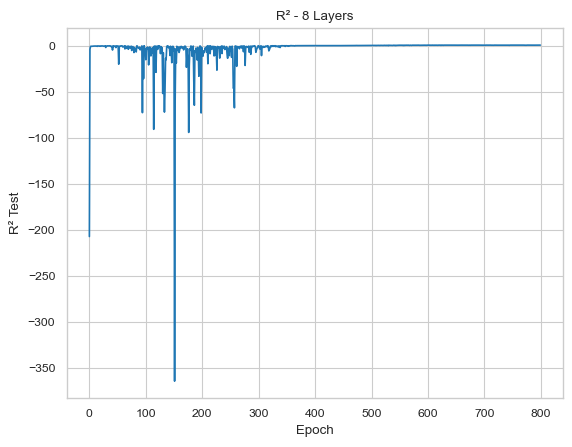

In [13]:
# Graficar el R² del conjunto de prueba al final de cada época
import matplotlib.pyplot as plt
plt.plot( r2_test_values)
plt.xlabel('Epoch')
plt.ylabel('R² Test')
plt.title('R² - 8 Layers')
plt.savefig("r2_8Layers.png", dpi=600)
plt.show()

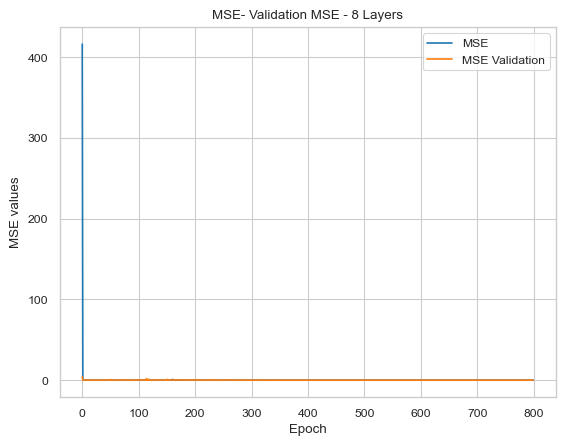

In [18]:
plt.plot(loss_values, label='MSE')
plt.plot(validation_values, label='MSE Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE values')
plt.title('MSE- Validation MSE - 8 Layers')
plt.legend()

plt.savefig("Loss_8Layers.png", dpi=600)
plt.show()

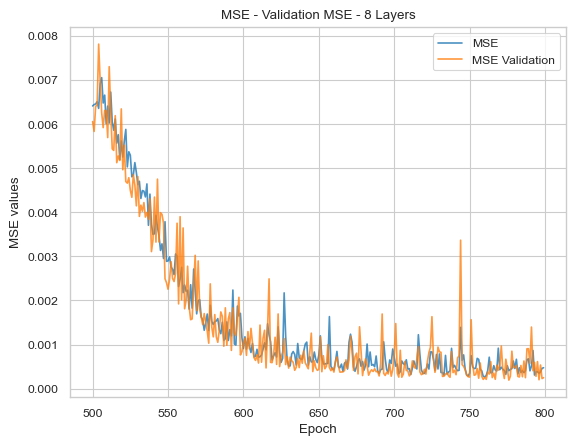

In [19]:
plt.plot(np.arange(500, 800), loss_values[500:], label='MSE', alpha=0.8)
plt.plot(np.arange(500, 800),validation_values[500:], label='MSE Validation', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE values')
plt.title('MSE - Validation MSE - 8 Layers')
plt.legend()

plt.savefig("Loss_8Layers_lastEpochs.png", dpi=600)
plt.show()

In [16]:
save_txt = np.concatenate((x_test_wavelength, y_test, predic), axis=1)
#print(save_txt)
df = pd.DataFrame(save_txt)
df.to_csv("matrixPredi8L.txt", sep=' ', index=False)